In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import re
from liftover import get_lifter
import seaborn as sns
import networkx as nx
import pickle
sys.path.append("/home/yanhu/DddA/DddA/tdac_seq")
from ddda_dataset import *
%matplotlib inline

In [3]:
# Create a folder to save plots
working_dir = "/home/yanhu/data/DddA/test_cases/"
os.system("mkdir -p " + working_dir)

0

In [207]:
# Create a dictionary for reference regions
ref_range_dict = {
    'test': ('chr11', 5245964, 5257447)
}

# Initialize ddda_dataset
ddda_data = ddda_dataset(
    ID = "test", 
    region_dict = ref_range_dict, 
    genome_file = "/home/yanhu/data/DddA/shared/refGenomes/hg38.fa", 
    fastq_file = "/home/yanhu/data/DddA/test_cases/test.fastq", 
    working_dir = "/home/yanhu/data/DddA/test_cases/"
)

# Load DddA bias model
with open("/home/yanhu/data/DddA/HJR245/bias_dict.pkl", "rb") as f:
    ddda_data.bias_model = pickle.load(f)
    
# Set all sequence bias to be 1 to simplify our simulation
for strand in ddda_data.bias_model:
    for kmer in ddda_data.bias_model[strand]:
        ddda_data.bias_model[strand][kmer] = 1
ddda_data.get_bias()

# Get the dictionary with the genomic sequence of our locus
ref_seq_dict = ddda_data.ref_seq_dict

Loading reference genome
Extracting sequences for each locus
Computing sequence bias


### Simulate reads with footprints and ABE edits

In [295]:
# Write simulated reads to the fastq files
locus = "test"
ref_seq = ddda_data.ref_seq_dict[locus]

# Decide whether to use forward strand (C-to-T, strand_ind = 0), or reverse (G-to-A, strand_ind = 1)
strand_ind = 0

# Randomly generate read start and end coordinate with respect to the reference sequence
read_start = np.random.randint(0, 200)
read_end = np.random.randint(len(ref_seq) - 200, len(ref_seq))

# Create a mask for artificial footprints
footprint_mask = np.zeros(len(ref_seq))
footprint_mask[1175:1225] = 1 # Make a 50 bp footprint
footprint_mask[1500:1600] = 1 # Make a 100 bp footprint
footprint_mask[1800:1950] = 1 # Make a 150 bp footprint

# Randomly select adenines to be edited by ABE
if strand_ind == 0:
    ABE_pos_list = [i for i in range(500, len(ref_seq) - 500) if ref_seq[i] == "A"]
elif strand_ind == 1:
    ABE_pos_list = [i for i in range(500, len(ref_seq) - 500) if ref_seq[i] == "T"]
ABE_edit_pos = np.random.choice(ABE_pos_list, 10)

# Set editing rate. edit_prob = 1 means every C will be edited unless inside a footprint
edit_prob = 1

# Generate the simulated read
simulated_read = []
simulated_DddA_edits = []
for i in range(read_start, read_end):

    # Simulate an ABE edit at the specified locations
    if i in ABE_edit_pos:
        if ref_seq[i] == "A":
            simulated_read.append("G")
        if ref_seq[i] == "T":
            simulated_read.append("C")
        continue

    # Simulate a DddA edit at the specified locations
    is_DddA_edited = False
    if footprint_mask[i] == 0: # If the current position is not overlapping with a footprint, we allow DddA edits to be simulated
        if (strand_ind == 0 and ref_seq[i] == "C") or (strand_ind == 1 and ref_seq[i] == "G"):
            is_DddA_edited = np.random.binomial(1, edit_prob) == 1
    if is_DddA_edited:
        simulated_read.append(["T", "A"][strand_ind])
        simulated_DddA_edits.append(1)

    else:
        simulated_read.append(ref_seq[i])
        simulated_DddA_edits.append(0)
simulated_read = "".join(simulated_read)
simulated_DddA_edits = np.array(simulated_DddA_edits)

# Write the simulated read to a fastq file
with open(os.path.join(working_dir, "test.fastq"), "w") as f:
    for line in [
        "@sim_read\n",
        simulated_read + "\n",
        "+\n",
        "".join(["~"] * len(simulated_read)) + "\n"
    ]:
        f.write(line)

### Test alignment and footprinting

In [296]:
# Align reads
gap_threshold = 500
ddda_data.align_reads(
    start_gap_threshold = gap_threshold,
    end_gap_threshold = gap_threshold,
    ABE_edits=True
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.66it/s]

1 reads aligned. 0 reads unaligned


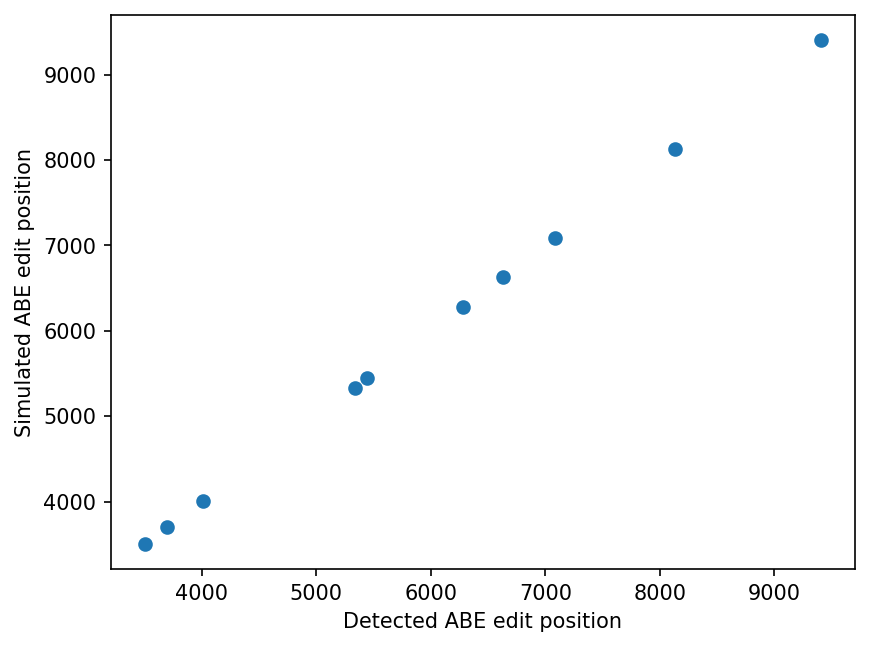

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [301]:
# Examine whether the detection of ABE edits is accurate
detected_ABE_edits = np.where(np.array(ddda_data.ABE_edit_dict[locus].todense())[0])[0]
ABE_edit_pos = sorted(np.array(ABE_edit_pos))

fig, ax = plt.subplots(dpi=150)
ax.scatter(detected_ABE_edits, ABE_edit_pos)
ax.set_ylabel("Simulated ABE edit position")
ax.set_xlabel("Detected ABE edit position")
plt.show()

detected_ABE_edits == ABE_edit_pos

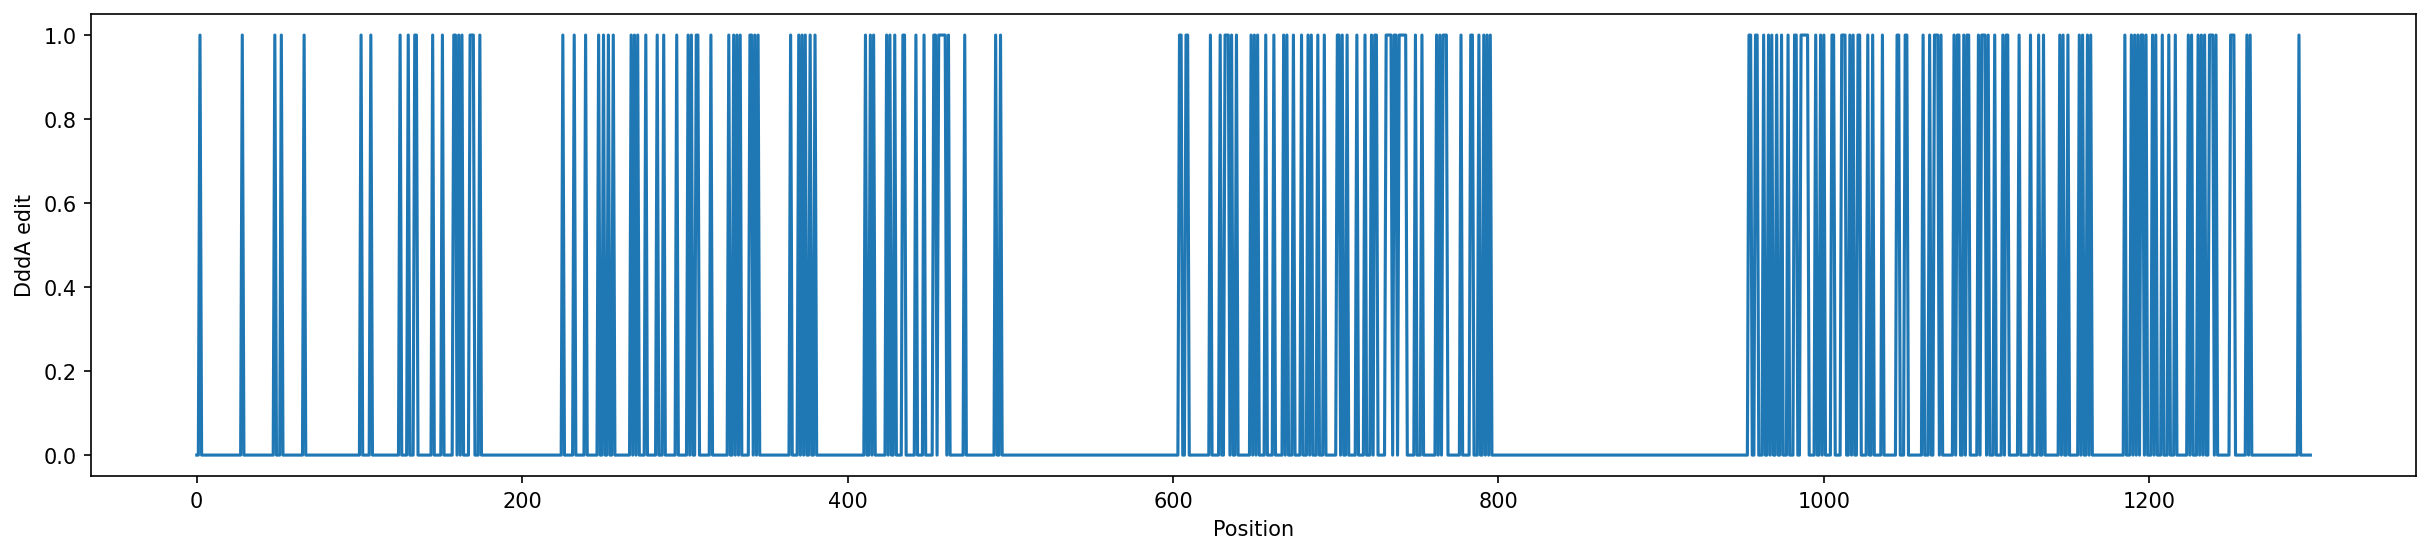

In [283]:
fig, ax = plt.subplots(dpi=150, figsize=(20, 4))
ax.plot(np.array(ddda_data.edit_dict[locus].todense())[0][1000:2300])
ax.set_ylabel("DddA edit")
ax.set_xlabel("Position")
plt.show()

Computing footprints for test


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


<Axes: >

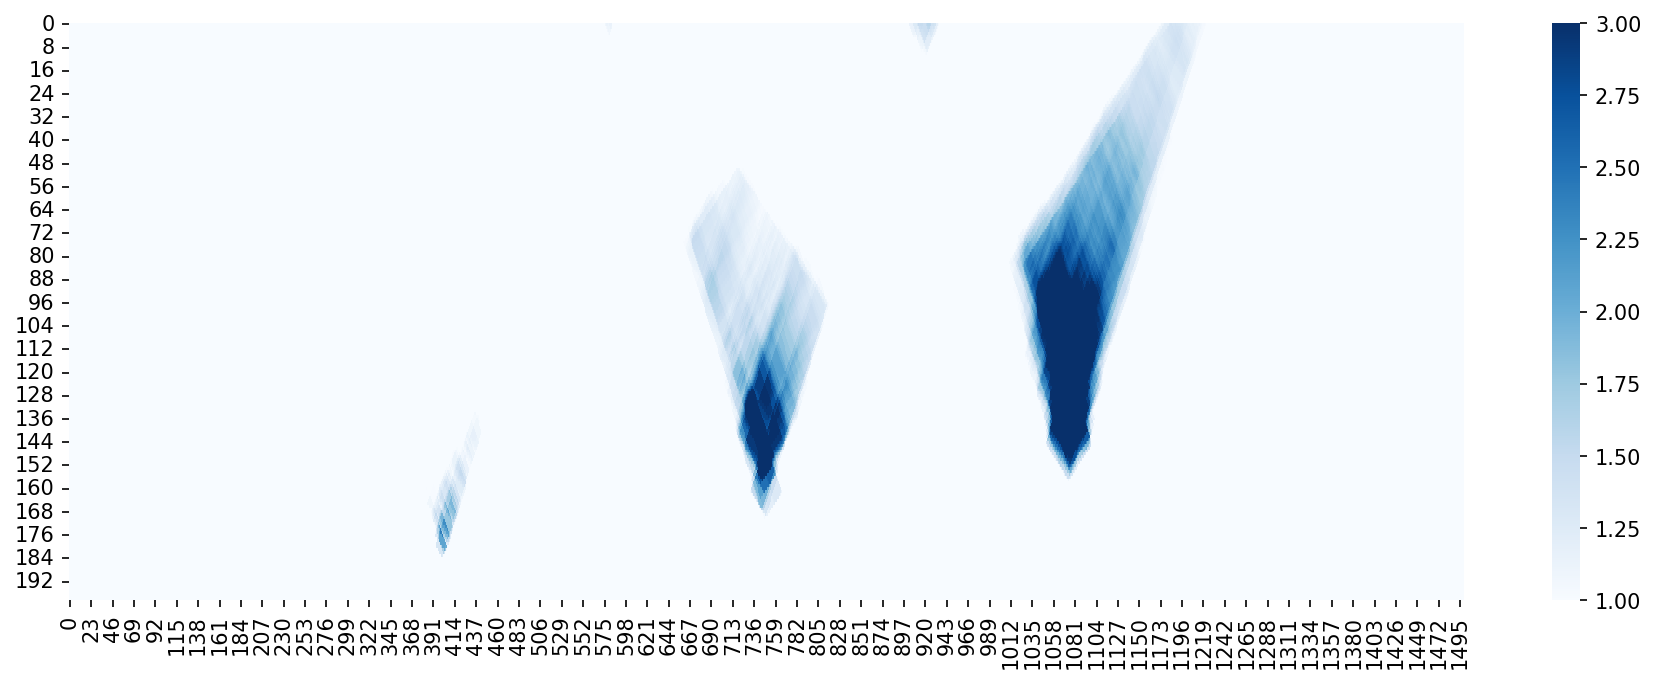

In [303]:
# Calculate multi-scale footprints
footprints = ddda_data.get_footprints(
    {locus:np.array(ddda_data.read_ids[locus])}, 
    footprint_radii = np.arange(1, 200), 
    combine_sides="max_pval")
read_footprints = footprints[locus]["sim_read"]
footprints = -np.log10(read_footprints)
footprints = np.flip(footprints, axis=0)

# Visualize footprints
plt.figure(dpi=150, figsize=(15,5))
sns.heatmap(footprints[:, 800:2300], vmax=3, vmin=1, cmap="Blues")